In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from google.cloud import storage
from tqdm import tqdm
storage_client = storage.Client()
bucket = storage_client.get_bucket('ah21_data')

In [2]:
import seaborn as sns
sns.set_style("dark")
sns.despine()

<Figure size 432x288 with 0 Axes>

In [9]:

def compute_averages_over_many_seeds(experiment_path, seed_subset=(0,100), verbose=False):
    
    potential_blobs = [str(blob).split()[2][:-1] for blob in storage_client.list_blobs(bucket,prefix=experiment_path)]
    seed_blobs = [blob for blob in potential_blobs if blob[-13:] == 'save/logs.txt'] 

    if verbose: print(">", seed_blobs)
    sorted_seed_blobs = []
    for i in range(len(seed_blobs)):
        if verbose: print(">>", i)        
        if i not in range(seed_subset[0],seed_subset[1]): continue
        for s in seed_blobs:
            if int(s.split("/")[-3].replace("seed_","")) == i:
                sorted_seed_blobs.append(s)
    print("number of sorted blobs = ", len(sorted_seed_blobs))

    seed_dictionaries = {}
    n_models = 7
    for ind, seed in enumerate(tqdm(sorted_seed_blobs)):

        blob = bucket.get_blob(seed)
        s = int(seed.split("/")[-3].replace("seed_",""))
        content = blob.download_as_string().decode('UTF-8').splitlines()
        tasks = [content[i-1] for i, c in enumerate(content) if '<openfl.component.aggregation_functions.weighted_average.WeightedAverage object at' in c][1::n_models]
        content = [c.split(">")[1][1:] for c in content if '<openfl.component.aggregation_functions.weighted_average.WeightedAverage object at' in c][1:]

        ## create a list of n_models*n_tasks tasks in the correct order as they appear in the tasks heading list (differs per seed)
        cnt = 0
        openfl_tasks = []
        for j in range(len(tasks)):
            t = [tasks[cnt] for model in range(n_models)]
            openfl_tasks.extend(t)
            cnt+=1    

        value_dictionary = {}
        for i, word in enumerate(content):
            task = openfl_tasks[i]
            key = task.replace(" task metrics...","")+"_"+word.split(":")[0]
            value = float(word.split(":")[1].replace("\t",""))

            if key in value_dictionary.keys():
                value_dictionary[key].append(value)
            else:
                value_dictionary[key] = [value]

        seed_dictionaries[s] = value_dictionary

    keys = list(seed_dictionaries[s].keys())
    keys.sort(reverse=True)

    mean_dictionary, std_dictionary, array_dictionary = {}, {}, {}
    for key in keys:
        mean_dictionary[key]  = np.mean( [seed_dictionaries[s][key] for s in seed_dictionaries.keys()], axis=0)
        std_dictionary[key]   = np.std(  [seed_dictionaries[s][key] for s in seed_dictionaries.keys()], axis = 0)
        array_dictionary[key] = np.array([seed_dictionaries[s][key] for s in seed_dictionaries.keys()] )

    return mean_dictionary, std_dictionary, keys

In [5]:
def plot_graphs(mean_dictionary, std_dictionary, keys):
    nrows = 3 # different metrics
    ncols = 7 # different models
    fig, ax = plt.subplots(nrows, ncols, figsize=(25,14))
    consistent_n_batches = 100

    ind = 0
    for i in range(nrows): 
        for j in range(ncols):       
            key = keys[ind]

            ind +=1
            x = np.linspace(1, consistent_n_batches, consistent_n_batches)
            y = mean_dictionary[key]
            ci = 1.96 * std_dictionary[key]

            l = key.replace("model_validation","").replace("ly_tuned","").replace("regated_", "").replace("model_","").replace("train_IRM_","")
            ax[i][j].plot(x,y, label=l)
            ax[i][j].fill_between(x, (y-ci), (y+ci), color='b', alpha=.05)
            ax[i][j].legend()

## Example 0a: simple regression

In [10]:
seed_subset = (0,5)
mean_dictionary, std_dictionary, keys = compute_averages_over_many_seeds('heavy_ion_experiment_reduced_new_code' , seed_subset)
plot_graphs(mean_dictionary, std_dictionary, keys)

0it [00:00, ?it/s]

['heavy_ion_experiment_reduced_new_code/seed_0/col_0/test/data.csv', 'heavy_ion_experiment_reduced_new_code/seed_0/col_0/train/data.csv', 'heavy_ion_experiment_reduced_new_code/seed_0/col_1/test/data.csv', 'heavy_ion_experiment_reduced_new_code/seed_0/col_1/train/data.csv', 'heavy_ion_experiment_reduced_new_code/seed_0/col_2/test/data.csv', 'heavy_ion_experiment_reduced_new_code/seed_0/col_2/train/data.csv', 'heavy_ion_experiment_reduced_new_code/seed_0/plan/', 'heavy_ion_experiment_reduced_new_code/seed_0/save/', 'heavy_ion_experiment_reduced_new_code/seed_0/save/log/', 'heavy_ion_experiment_reduced_new_code/seed_1/col_0/test/data.csv', 'heavy_ion_experiment_reduced_new_code/seed_1/col_0/train/data.csv', 'heavy_ion_experiment_reduced_new_code/seed_1/col_1/test/data.csv', 'heavy_ion_experiment_reduced_new_code/seed_1/col_1/train/data.csv', 'heavy_ion_experiment_reduced_new_code/seed_1/col_2/test/data.csv', 'heavy_ion_experiment_reduced_new_code/seed_1/col_2/train/data.csv', 'heavy_ion_

UnboundLocalError: local variable 's' referenced before assignment

## Example 0b: simple classification

  0%|          | 0/20 [00:00<?, ?it/s]

number of sorted blobs =  20


100%|██████████| 20/20 [00:07<00:00,  2.78it/s]


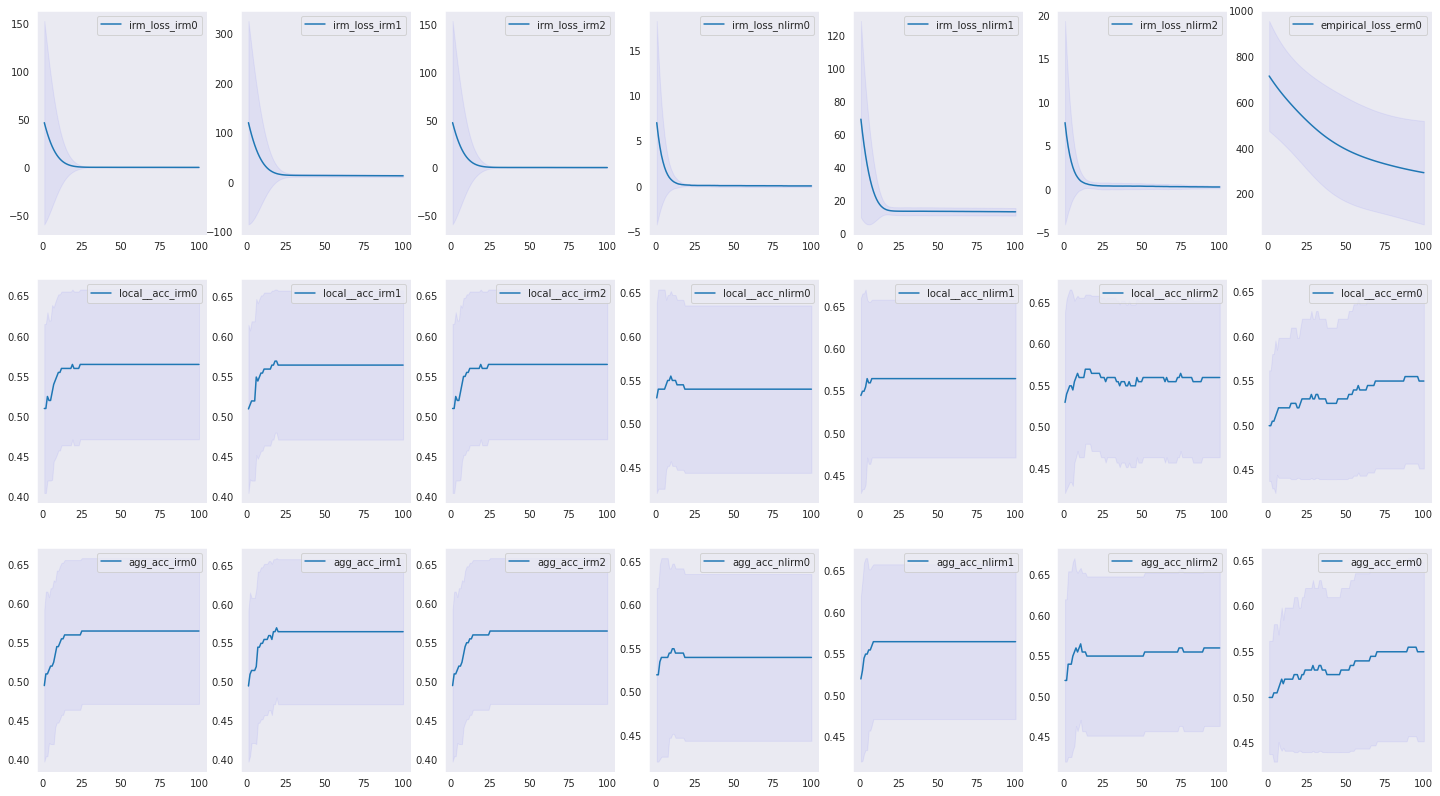

In [7]:
seed_subset = (0,20)
mean_dictionary, std_dictionary, keys = compute_averages_over_many_seeds('validation/Example0b_dim_inv_5_dim_spu_5_dim_unc_0_n_exp_3000_n_env_3' , seed_subset)
plot_graphs(mean_dictionary, std_dictionary, keys)